In [1]:
import sys
sys.path.insert(1, "../input/apxembeddings-utils/")

In [2]:
import torch
import torch.nn as nn
from transformers import AutoModel
import numpy as np
import matplotlib.pyplot as plt
import time

from apx import ApproxEmbed2, train_apx, load_runs, plot_compare_result_runs, set_random_seed

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.__version__

'2.0.0.dev20230123+cu117'

In [4]:
model = AutoModel.from_pretrained('prajjwal1/bert-tiny')
embeddings=model.embeddings.word_embeddings.weight
embeddings.shape

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([30522, 128])

In [5]:
set_random_seed(42)

In [6]:
LEVELS=[2,4,8,16,32]
CHANNELS=[2,4,8,16,32]
bits=8
device='cuda'
epochs=5000
batch_size=2**14
neurons=64
nn_levels=2
n_embeddings=embeddings.shape[0]
embeddings_size=embeddings.shape[1]
checkpoint_every=100

save_path='results/compression_pretrained/'

import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [7]:
embeddings=embeddings.to(device)

for levels in LEVELS:
    for channels in CHANNELS:
        
        print(levels,channels)
        
        # create the approximation structure
        apx=ApproxEmbed2(levels = levels, 
                feature_dim = channels,
                num_words = n_embeddings,
                output_dims = embeddings_size,
                feature_std = 0.1,
                feature_bias = 0.0,
                codebook_bitwidth=bits,
                neurons = neurons,
                nn_levels=nn_levels)
        apx.to(device)

        run = train_apx(apx=apx, 
                        embeddings=embeddings, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        checkpoint_every=checkpoint_every, 
                        save_path=save_path)

2 2


KeyboardInterrupt: 

In [ ]:
runs = load_runs(save_path)

In [ ]:
for run in runs:
    run['apx'].fix_indices()

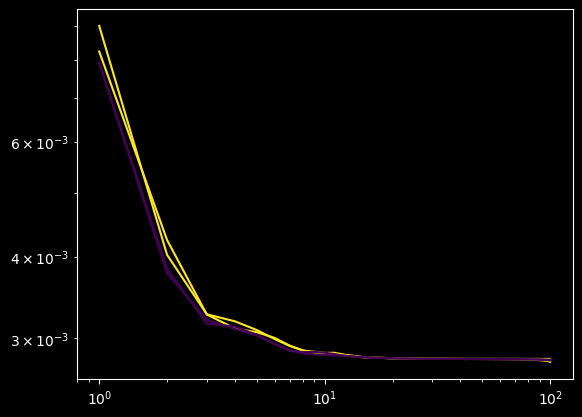

In [ ]:
color = plt.cm.viridis(1-np.linspace(0, 1, len(LEVELS)))
for run in runs:
    plt.plot(np.arange(len(run['loss']))+1,run['loss'],color=color[np.where(np.array(LEVELS)==run['level'])])
    plt.yscale('log')
    plt.xscale('log')

2
4


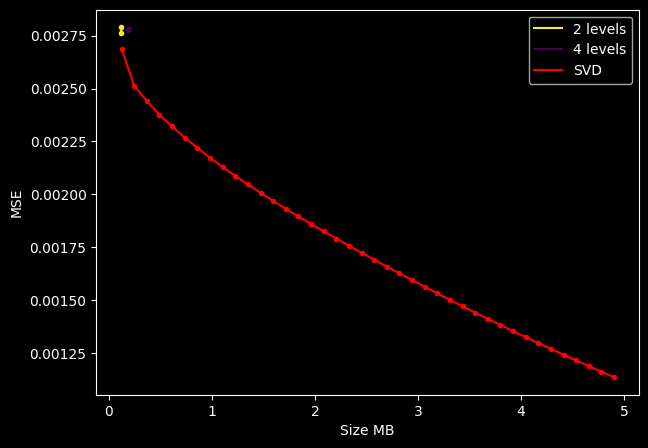

In [ ]:
plot_compare_result_runs(runs,embeddings)